# CNN 모델을 이용해서 MNIST 숫자 분류

In [1]:
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

train_dataset_path = r"D:\NoShare\MNIST_CSV\mnist_train.csv"
test_dataset_path = r"D:\NoShare\MNIST_CSV\mnist_test.csv"

train_dataset = pd.read_csv(train_dataset_path)
test_dataset = pd.read_csv(test_dataset_path)

# Image와 Label 분리한다.
train_images = (train_dataset.iloc[:, 1:].values).astype("float32")
train_labels = train_dataset["label"].values
test_images = (test_dataset.iloc[:, 1:].values).astype("float32")

# Test와 Valid 데이터셋을 나눠준다.
train_images, valid_images, train_labels, valid_labels = train_test_split(
    train_images, 
    train_labels, 
    stratify=train_labels,  # 분포를 train_labels의 분포로 분리하겠다.
    random_state=42,        # 랜덤 시드를 생성하여 분리
    test_size=0.2,          # test_size를 결정
)

# Reshape을 통해서 이미지의 형태로 바꿔준다.
train_images = train_images.reshape(train_images.shape[0], 28, 28)
valid_images = valid_images.reshape(valid_images.shape[0], 28, 28)
test_images = test_images.reshape(test_images.shape[0], 28, 28)

batch_size = 64

# Tensor로 변환해주고, DataLoader를 붙여서 미니배치모드로 학습할 수 있도록 해준다.
train_image_tensors = torch.tensor(train_images)
train_label_tensors = torch.tensor(train_labels)
train_tensor = TensorDataset(train_image_tensors, train_label_tensors)
train_loader = DataLoader(train_tensor, batch_size=batch_size, num_workers=0, shuffle=True)

valid_image_tensors = torch.tensor(valid_images)
valid_label_tensors = torch.tensor(valid_labels)
valid_tensor = TensorDataset(valid_image_tensors, valid_label_tensors)
valid_loader = DataLoader(valid_tensor, batch_size=batch_size, num_workers=0, shuffle=True)

test_image_tensors = torch.tensor(test_images)

In [2]:
import torch 

# GPU 사용 여부를 체크
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

print(DEVICE)

cuda


# CNN 모델 쌓기

## 눈여겨볼 부분
```python
# 1, 10 -> 10, 20
self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
# 어떻게 320이 나왔는가?
self.fc1 = nn.Linear(320, 50)
self.fc2 = nn.Linear(50, 10)
```

## Pytorch 문서

+ Conv2d 항목
    ```
    torch.nn.Conv2d(
        in_channels: int, out_channels: int, kernel_size: Union[T, Tuple[T, T]], 
        stride: Union[T, Tuple[T, T]] = 1, padding: Union[T, Tuple[T, T]] = 0, 
        dilation: Union[T, Tuple[T, T]] = 1, groups: int = 1, bias: bool = True, padding_mode: str = 'zeros'
    )
    ```
+ MaxPool2d 항목
    ```
    torch.nn.MaxPool2d(
        kernel_size: Union[T, Tuple[T, ...]], stride: Optional[Union[T, Tuple[T, ...]]] = None, 
        padding: Union[T, Tuple[T, ...]] = 0, dilation: Union[T, Tuple[T, ...]] = 1, 
        return_indices: bool = False, ceil_mode: bool = False
    )

    ...
    stride – the stride of the window. 기본값은 kernel_size와 같다.
    ...
    ```


## 모델 해설
+ in_channels가 1 : 흑백 이미지
+ out_channels 10 : 5*5짜리 필터가 10개 생성됨.
+ in_channels  10 : 10개의 필터가 입력됨.
+ out_channels 20 : 5*5짜리 필터가 20개 생성됨.
---
### 계산법
#### Output tensor size 계산법 : 
$I$ = input width  
$K$ = kernel width  
$P$ = padding  
$S$ = stride  
$O = (I - K + 2 X P ) / S + 1$

####  Maxpool layer를 통과한 Output tensor size : O = ( input_size - kernel_size ) / s + 1
$I$ = input width  
$K$ = kernel width  
$S$ = stride  
$O = (I - K) / S + 1$

---

### self.conv1
+ size = width 를 말한다.
+ input size 28, channel 1 (흑백)
+ kernel size 5 
+ output channel 10 (커널 또는 필터가 10개)
+ padding = 0, stride = 1 (기본값)
+ output image의 size $O = (28 - 5 + 0) / 1 + 1 = 24$
+ conv1의 출력 Tensor size $O = 24 * 24 * 10$

### max_pool(self.conv1(x), 2) 해석
+ input : $24 * 24 * 10$
+ kernel size : 2
+ output image의 size $O = (24 - 2) / 2 + 1 = 12 $
+ 출력 Tensor size $O = 12 * 12 * 10$

### max_pool(self.conv1(x), 2) 동일
+ output image size
    + conv2 : $O = (12-5)/1 + 1 = 8$
    + max_pool : $O = (8-2)/2 + 1 = 4$
+ 출력 Tensor size
    + conv2 : $O = 8 * 8 * 20$
    + max_pool : $O = 4 * 4 * 20$ 
### fc1 해설
+ input : 4 * 4 * 20 = 320
+ output : 50
...

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 1, 10 -> 10, 20 (흑백 1채널이 들어가서 20개의 필터가 생성됨)
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # 어떻게 320이 나왔는가?
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x)
        return x

model = CNN().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)

model

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [4]:
def train(epoch, model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                    
def evaluate(model, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            valid_loss += F.cross_entropy(output, target, reduction = "sum").item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    valid_loss /= len(valid_loader.dataset)
    valid_accuracy = 100. * correct / len(valid_loader.dataset)
    return valid_loss, valid_accuracy

In [5]:
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(epoch, model, train_loader, optimizer)
    valid_loss, valid_accuracy = evaluate(model, valid_loader)
    print(f"[EPOCH: {epoch}], \tValidation Loss: {valid_loss:.4f}, \tValidation Accuracy: {valid_accuracy:.2f} %\n")

Train Epoch: 1 [0/48000 (0%)]	Loss: 17.014259
Train Epoch: 1 [6400/48000 (13%)]	Loss: 0.188758
Train Epoch: 1 [12800/48000 (27%)]	Loss: 0.226810
Train Epoch: 1 [19200/48000 (40%)]	Loss: 0.133297
Train Epoch: 1 [25600/48000 (53%)]	Loss: 0.193722
Train Epoch: 1 [32000/48000 (67%)]	Loss: 0.155734
Train Epoch: 1 [38400/48000 (80%)]	Loss: 0.188817
Train Epoch: 1 [44800/48000 (93%)]	Loss: 0.111365
[EPOCH: 1], 	Validation Loss: 0.0931, 	Validation Accuracy: 97.36 %

Train Epoch: 2 [0/48000 (0%)]	Loss: 0.046694
Train Epoch: 2 [6400/48000 (13%)]	Loss: 0.095769
Train Epoch: 2 [12800/48000 (27%)]	Loss: 0.053032
Train Epoch: 2 [19200/48000 (40%)]	Loss: 0.130537
Train Epoch: 2 [25600/48000 (53%)]	Loss: 0.029070
Train Epoch: 2 [32000/48000 (67%)]	Loss: 0.097211
Train Epoch: 2 [38400/48000 (80%)]	Loss: 0.199755
Train Epoch: 2 [44800/48000 (93%)]	Loss: 0.079085
[EPOCH: 2], 	Validation Loss: 0.0749, 	Validation Accuracy: 97.90 %

Train Epoch: 3 [0/48000 (0%)]	Loss: 0.011924
Train Epoch: 3 [6400/48000 (

In [6]:
def testset_prediction(model, test_image_tensor):
    model.eval()
    result = []
    with torch.no_grad():
        for data in test_image_tensor:
            data = data.to(DEVICE)
            output = model(data)
            prediction = output.max(1, keepdim = True)[1]
            result.append(prediction.tolist())
    return result

In [7]:
test_predict_result = testset_prediction(model, test_image_tensors)
test_predict_result[:5]

[[[7]], [[2]], [[1]], [[0]], [[4]]]

In [8]:
import numpy as np
from collections import Counter

# 예측결과의 분포 확인
Counter(np.squeeze(test_predict_result)).most_common()

[(1, 1140),
 (2, 1036),
 (7, 1019),
 (3, 1019),
 (9, 1012),
 (0, 988),
 (4, 979),
 (8, 970),
 (6, 951),
 (5, 886)]

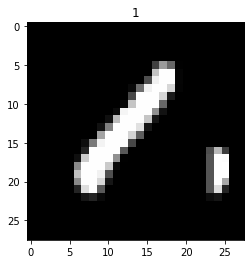

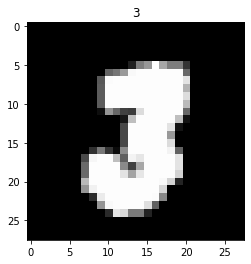

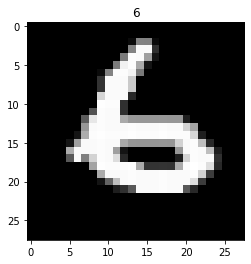

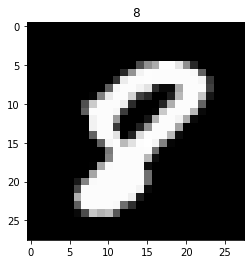

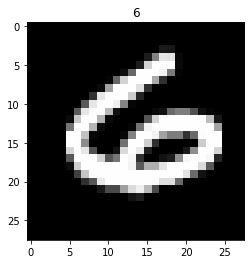

In [9]:
from matplotlib import pyplot as plt
import numpy as np 

# image 시각화 함수
def imshow(img, label):
    plt.imshow(img, cmap=plt.get_cmap("gray"))
    plt.title(label)
    plt.show()

# 이미지 확인하기
for i in range(5):
    imshow(train_images[i], train_labels[i])